## KBDI using mm and C

$$
KBDI_{t} = Q_{t} + \frac{(203.2 - Q_{t}) (0.968 e^{0.0875 T_{t}+1.5552} - 8.30) Δt}{1 + 10.88 e^{-0.001736 P}} * 1^{-3}
$$

where: 

$Q_{t}$ = $max(0, KBDI_{t-1} − 1 - Pnet_{t})$ 

$Pnet_{t}$ is net precip (mm/day), real complicated see code

$T$ is daily maximum temperature (C)

$Δt = 1$ (day)

$P$ is long term mean annual precip (mm)

and 

$KBDI_{t-1}$ is intialized to 0 at whatever time meets the wet condition criteria of 203.2 mm in a week, all times before that are nan


In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import dask
import dask.array as da

import matplotlib.pyplot as plt

In [5]:
pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

# pr_file = r'E://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
# tmax_file = r'E://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'



chunk3D = {'time':-1,'lat':50,'lon':50}

# Steps

1) find the starting day of the calculation at each grid cell (KBDI initialization)
    - when the running sum of precip over a 1 week period is greater than 152mm (or 203?)
    - the starting day for calculating KBDI is the next day (after the week that qualifies above) 
2) calculate rr for the whole timeseries at each grid (the number of consecutive days with rain)
3) calculate Pnet of t
4) calculate Q of t0 using KBDI of t-1 = 0
5) calculate KBDI

# 1) KBDI Initialization date at each grid cell

Finding the first possible day at each grid where we can set the initial value of KBDI to zero. This requires a preceding wet period where at least 152mm of precip falls with 1 week.

In [6]:
# pr=xr.open_dataset(pr_file).prcp.sel(time=slice('1951','1960'),lat=slice(30,32),lon=slice(-90,-88)).round(2).load()
pr=xr.open_mfdataset(pr_file,chunks=chunk3D).prcp.sel(time=slice('1951','1960')).round(2)#.load()
pr

<xarray.DataArray 'prcp' (time: 3653, lat: 358, lon: 753)> Size: 4GB
dask.array<round, shape=(3653, 358, 753), dtype=float32, chunksize=(3653, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 29kB 1951-01-01 1951-01-02 ... 1960-12-31
  * lat          (lat) float32 1kB 24.56 24.6 24.65 24.69 ... 39.35 39.4 39.44
  * lon          (lon) float32 3kB -106.6 -106.6 -106.5 ... -75.35 -75.31 -75.27
    spatial_ref  int64 8B ...
Attributes:
    id:                /workspace/home2/home/imke.durre/active/live/products/...
    long_name:         Precipitation, daily total
    valid_max:         2000.0
    standard_name:     precipitation_amount
    naming_authority:  gov.noaa.ncei
    source:            GHCN-Daily CSV files 
    comment:           Values should be rounded to the nearest hundredth. Eac...
    units:             mm/day
    reference:         https://doi.org/10.1175/JTECH-D-22-0024.1
    valid_min:         0.0
    metadata_link:     https://doi.org/10.25921/c4gt-r169

dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray> data points (grids) over land


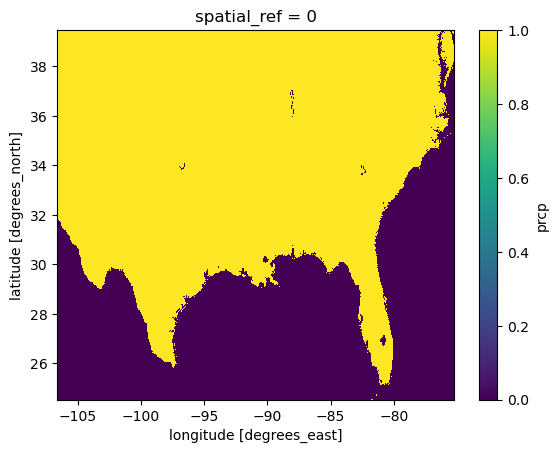

In [7]:
# make a land/sea 1/0 mask (to help us keep track of where the nans should be)
landmask=xr.where(np.isfinite(pr.mean('time')),1,0)
nlandpts = landmask.sum().data
print(f'{nlandpts} data points (grids) over land')
landmask.plot()

In [ ]:
# create an integer time index since datetimes will give us some trouble
time_index=np.arange(0,len(pr.time)).astype('int')
pr.coords['time_index']=('time',time_index)
pr

In [ ]:
# sum precip in 7 day rolling windows
ndays=7
pr_thresh=152
pr_weeksum=pr.rolling(time=ndays,min_periods=4,center=False).sum()
pr_weeksum

In [ ]:
# look at the max 7 day sum
pr_weeksum.max('time').plot()

In [ ]:
# get the first index time where the weekly sum meets the threshold
day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')
day_index

In [ ]:
print(day_index.min().data, day_index.max().data)

assert day_index.min().data >= 7,f'found intialization at index {day_index.min().data.item()}'

In [ ]:
# look at the result
day_index.plot()

In [ ]:
# are there any grids where we didn't find a time index (more nans than the landmask)

nnan_mask=landmask.sum().data # nans in the landmask (ocean points)
nnan_data=xr.where(np.isfinite(day_index),1,0).sum().data # nan grids in our initialization index (should be only ocean points)

assert nnan_mask == nnan_data, f'there are {nnan_data - nnan_mask} grid cells where a KBDI initialization index was not found'

figure out which day of the week/window is given in our index, is it the first day or last day?

In [ ]:
# look at rolling pr and plot the threshold as well as the date where the threshold is met for a single grid
fig=plt.figure(figsize=(15,2))
plt.axhline(y=pr_thresh,color='grey',linestyle='dashed',linewidth=0.5)  # threshold guide line
plt.axvline(x=pr_weeksum.time[day_index.isel(lat=0,lon=0).astype('int').item()].data,color='red')
pr_weeksum.isel(lat=0,lon=0).plot()

In [ ]:
# zoom in
fig=plt.figure(figsize=(15,2))
plt.axhline(y=pr_thresh,color='grey',linestyle='dashed',linewidth=0.5)  # threshold guide line
plt.axvline(x=pr_weeksum.time[day_index.isel(lat=0,lon=0).astype('int').item()].data,color='red')
pr_weeksum.isel(lat=0,lon=0).sel(time=slice('1952-07-05','1952-07-19')).plot()

In [ ]:
# do a little test of rolling on this grid for these dates
test=pr.isel(lat=0,lon=0).sel(time=slice('1952-07-05','1952-07-19')).rolling(time=ndays,min_periods=4,center=False).sum()
test

Because we chose min_periods=4 and the first 3 values are nan we can see that .rolling with center=False returns the sum of the 7 day window with the time label on the last day in the window. So the sum is of that day plus the preceding 6 days

**Therefore, this index/date is the KBDI initialization time t-1. The first KBDI will be computed one day after this at time t.**

# 2) rr, number of consecutive days with rain

In [ ]:
# coding it up for a single grid first
prsub=pr.isel(lat=0,lon=0)
prsub

In [ ]:
rainmask=xr.where(prsub>0,1,0)

In [ ]:
# calculate number of consecutive rain days

# I got this code to interrupt a cumulative sum here:
# https://stackoverflow.com/questions/61753567/convert-cumsum-output-to-binary-array-in-xarray
rr=rainmask.cumsum()-rainmask.cumsum().where(rainmask == 0).ffill(dim='time').fillna(0)
rr

In [ ]:
# let's see if it's really working
fig=plt.figure(figsize=(15,2))
plt.axhline(y=0,color='grey')  # threshold guide line
plt.ylim([-1,10])
prsub.sel(time=slice('1951-01-01','1951-01-31')).plot()
rr.sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)

wow, ok it is working. blue line is daily precip, orange dots are the number of consecutive rain days.

Now do this to the whole array...

In [ ]:
# same thing, whole array
rainmask=xr.where(pr>0,1,0)
rr=rainmask.cumsum('time')-rainmask.cumsum('time').where(rainmask == 0).ffill(dim='time').fillna(0)
print(rr.shape)

# plot should be identical
fig=plt.figure(figsize=(15,2))
plt.axhline(y=0,color='grey')  # threshold guide line
plt.ylim([-1,10])
pr.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1951-01-31')).plot()
rr.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)

plots for the test grid are identical

In [ ]:
# check a single time in space
rr.sel(time='1951-01-15').plot()

we need to put the nans back

In [ ]:
# put nans back
# .where reorders dims so we need .transpose to get original dim order back
rr=xr.where(landmask,rr,np.nan).transpose('time','lat','lon') 
# rr

In [ ]:
# check a single time in space
rr.sel(time='1951-01-15').plot()

looks good (note the different scales)

# 3) Pnet

In order to obtain net rainfall, 0.2 inch has to be subtracted from any daily rainfall amount exceeding 0.2 inch. In the case of consecutive days with rainfall, the 0.2 inch has to be subtracted on the exact day when the summed rainfall amount exceeds 0.2 inch. If the daily rainfall amount is smaller than 0.2, then net rainfall equals zero. Finally, net rainfall, expressed in hundredths of an inch, has to be subtracted from Q.

Pnet of t = max( 0, (P of t) - max(0, Plim - ∑ over i=1 to rr-1 of P of t−i)) 

I have no idea what this equation means, it doesn't seem to match the text description of how to calculate Pnet at all. Also, it's never explained what Plim is.

Approach:

- split the timeseries into categories (modify rr into the following categories)
    - category 0: days not in a consecutive rain event
        - days where no rain falls
        - days where less than 0.2 inch (5.08 mm) falls but is not part of a consecutive day rain event
        - days where more than 0.2 inch (5.08 mm) falls but is not part of a consecutive day rain event
    - category 1: days in a consecutive day rain event
        - this means any day that is in a consecutive day rain event regardless of over/under threshold
        - we'll have to loop through each consecutive rain event and
            - accumulate rainfall totals over consecutive days
            - rain amounts (lt 5.08 mm) on days before threshold is met should be set to 0
            - subtract 0.2 inches (5.08 mm) only from the exact day when threshold is met
            - rain amounts on days after threshold is met should remain unchanged and add to the accumulation

In [ ]:
# this function creates two categories of rain days
# cat 0 is a day that is not part of a consecutive-day rainfall event
# cat 1 is a day that IS part of a consecutive-day rainfall event

def create_categories(rr_chunk,chunk_id):
    # for all consecutive rain events 
    # replace the third or greater day's value with an integer that is not 0, 1, or 2, we'll use 5
    cat_chunk=xr.where(rr_chunk>=3,5,rr_chunk)

    # we now need to find whether day 1's should be cat0 or cat1
    # we'll know the answer based on whether the following day is a 2
    
    # find all indexes of the second day of consecutive rain events
    day2_iii=np.argwhere(rr_chunk==2)

    # loop through the indexes found above and replace those 
    # day's values as well as the previous day's value with 5
    for i in range(day2_iii.shape[0]):
        # replace day 2's value with 5
        cat_chunk[day2_iii[i,0],day2_iii[i,1],day2_iii[i,2]] = 5    
        # replace day 1's value with 5
        cat_chunk[day2_iii[i,0]-1,day2_iii[i,1],day2_iii[i,2]] = 5    

    # days in a consecutive day rain event are 1
    # days not in a consecutive day rain event are 0
    # nan exists for non-data grids (over ocean cells)
    cat_chunk=xr.where(cat_chunk==1,0,cat_chunk)
    cat_chunk=xr.where(cat_chunk==5,1,cat_chunk)

    # make sure there are not more than 3 different values (0,1,nan) present
    assert len(np.unique(cat_chunk))<=3,f'too many category values {np.unique(cat_chunk)} in chunk id {chunk_id}' 

    return cat_chunk

In [ ]:
# chunk over longitude for parallel processing
rr=rr.chunk({'time':-1,'lat':-1,'lon':3})

# delay the data chunks and get them into a 1D list
rr_delayed=rr.data.to_delayed().ravel()
len(rr_delayed)

In [ ]:
%%time
# do the calculation

# list of delayed compute tasks (1 for each chunk)
task_list=[dask.delayed(create_categories)(rr_chunk,id) for id,rr_chunk in enumerate(rr_delayed)]

# compute in parallel
result_chunks=dask.compute(*task_list)

# concatenate results
cat_np=np.concatenate(result_chunks,axis=2)

# numpy to xarray
cat=xr.DataArray(cat_np,coords=rr.coords)
cat.shape

In [ ]:
cat.sel(time='1951-01-15').plot()

We now have an array where every time at every grid falls into either cat 1 (day in consecutive rain event), cat 0 (day not in a consecutive rain event), or is nan. 

Next we have to loop in time to find the daily Pnet. Testing first on a single grid

In [ ]:
# subset to single grid
rr_sub=rr[:,0,0].compute()
cat_sub=cat[:,0,0]
pr_sub = pr[:,0,0]
rr_sub.shape,cat_sub.shape,pr_sub.shape

In [ ]:
# initialize to nan
Pnet = rr_sub.copy()
Pnet[:]=np.nan

In [ ]:
# Pnet condition for days not in consecutive rain event
# subtract 5.08mm from precipitation amount
# and if negative, replace with 0
thresh = 5.08
Pnet = xr.where(cat_sub==0, pr_sub-thresh, Pnet)
Pnet = xr.where(Pnet<0,0,Pnet)

In [ ]:
# now loop through consecutive rain events to find cumulative pr


# initializations
thresh_flag=False
accpr=0.

for i,(catval,prval) in enumerate(zip(cat_sub,pr_sub)):

    # set/reset accpr to 0 and threshold flag when not raining consec days
    if catval==0:
        accpr=0.
        thresh_flag=False

    # if consec day rain
    # subtract threshold where appropriate
    # and accumlate rainfall over the event    
    if catval==1:
        accpr=accpr+prval # accumulated precip
        # if not over the threshold yet, Pnet is 0
        if accpr<thresh and not thresh_flag:
            Pnet[i]=0
        # on the day the threshold is met, subtract the threshold amount and change flag    
        elif accpr>=thresh and not thresh_flag:
            accpr=accpr-thresh # modify accumulated precip
            Pnet[i]=accpr
            thresh_flag=True
        # any days after the threshold is met will accumulate with no limitations or subtractions   
        else:
            Pnet[i]=accpr            

In [ ]:
# plot should be identical
fig=plt.figure(figsize=(15,2))
plt.axhline(y=5.08,color='grey')  # threshold guide line
plt.ylim([-1,10])
Pnet.sel(time=slice('1951-01-01','1951-01-31')).plot()  # blue line
pr_sub.sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)  # orange circle

In [ ]:
Pnet.min().item(),Pnet.max().item()

Looks like it's working correctly. Now apply to whole array. This is a time loop that will have to be applied to every grid cell. We'll send 3D chunks of data to the function and loop through the timeseries for each grid cell

In [ ]:
# function to calculate the 3D array Pnet

def calc_pnet(cat_arr,pr_arr):
    # initializations and constants
    thresh = 5.08 # mm
    thresh_flag=False
    accpr=0.
    
    # calc pnet where not consecutive day rain
    pnet = np.where(cat_arr==0, pr_arr-thresh, np.nan)
    pnet = np.where(pnet<0,0,pnet)

    # loops required for days in consec day rain
    for ilat in range(cat_arr.shape[1]):
        for ilon in range(cat_arr.shape[2]):
            for itime,(cat,pr) in enumerate(zip(cat_arr[:,ilat,ilon],pr_arr[:,ilat,ilon])):
    
                # set/reset accpr to 0 and threshold flag when not raining consec days
                if cat==0:
                    accpr=0.
                    thresh_flag=False
            
                # if consec day rain
                # subtract threshold where appropriate
                # and accumlate rainfall over the event    
                if cat==1:
                    accpr=accpr+pr # accumulated precip
                    # if not over the threshold yet, Pnet is 0
                    if (accpr<thresh) and (not thresh_flag):
                        pnet[itime,ilat,ilon]=0
                    # on the day the threshold is met, subtract the threshold amount and change flag    
                    elif (accpr>=thresh) and (not thresh_flag):
                        accpr=accpr-thresh # modify accumulated precip
                        pnet[itime,ilat,ilon]=accpr
                        thresh_flag=True
                    # any days after the threshold is met will accumulate with no limitations or subtractions   
                    else:
                        pnet[itime,ilat,ilon]=accpr  
    return pnet

In [ ]:
# chunk, delay, ravel
chunk={'time':-1,'lat':-1,'lon':3}
cat=cat.chunk(chunk)
pr=pr.chunk(chunk)
cat_delayed=cat.data.to_delayed().ravel()
pr_delayed=pr.data.to_delayed().ravel()
len(cat_delayed),len(pr_delayed)

In [ ]:
%%time
# do the calculation

# list of delayed compute tasks (1 for each chunk)
task_list=[dask.delayed(calc_pnet)(cat_chunk,pr_chunk) for cat_chunk,pr_chunk in zip(cat_delayed,pr_delayed)]

# compute in parallel
result_chunks=dask.compute(*task_list)

# concatenate results
pnet_np=np.concatenate(result_chunks,axis=2)

# numpy to xarray
Pnet=xr.DataArray(pnet_np,coords=pr.coords)
Pnet.shape

In [ ]:
# results should be identical for the test grid we did earlier, let's check it
fig=plt.figure(figsize=(15,2))
plt.axhline(y=5.08,color='grey')  # threshold guide line
plt.ylim([-1,10])
Pnet.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1951-01-31')).plot()  # blue line
pr.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1951-01-31')).plot(marker='o',linewidth=0)  # orange circle

In [ ]:
Pnet.min().item(),Pnet.max().item()

Pnet takes a lot of time on larger arrays. We need to change the loops to where statements

In [ ]:
cat

In [ ]:
cat = cat.compute()
pr = pr.compute()

In [ ]:
%%time
# initializations and constants
thresh = 5.08 # mm
thresh_flag=cat.data.astype('bool')
thresh_flag[:,:,:]=False
accpr= thresh_flag.astype('float32')
accpr[:,:,:]=0

# calc pnet where not consecutive day rain
pnet = np.where(cat==0, pr-thresh, np.nan)
pnet = np.where(pnet<0,0,pnet)
# pnet.shape,pnet.dtype

# # loops required for days in consec day rain
# for ilat in range(cat_arr.shape[1]):
#     for ilon in range(cat_arr.shape[2]):
        
for itime in range(cat.shape[0]):
    #enumerate(zip(cat_arr[:,ilat,ilon],pr_arr[:,ilat,ilon])):
    cat_arr = cat[itime,:,:]
    pr_arr = pr[itime,:,:]
    
    # set/reset accpr to 0 and threshold flag when not raining consec days
    accpr = np.where(cat_arr==0,0,accpr)
    thresh_flag = np.where(cat_arr==0,False,thresh_flag)

    # # if consec day rain
    # # subtract threshold where appropriate
    # # and accumlate rainfall over the event    
    # if cat==1:
    #     accpr=accpr+pr # accumulated precip
    #     # if not over the threshold yet, Pnet is 0
    #     if (accpr<thresh) and (not thresh_flag):
    #         pnet[itime,ilat,ilon]=0
    #     # on the day the threshold is met, subtract the threshold amount and change flag    
    #     elif (accpr>=thresh) and (not thresh_flag):
    #         accpr=accpr-thresh # modify accumulated precip
    #         pnet[itime,ilat,ilon]=accpr
    #         thresh_flag=True
    #     # any days after the threshold is met will accumulate with no limitations or subtractions   
    #     else:
    #         pnet[itime,ilat,ilon]=accpr  
accpr.dtype,thresh_flag.dtype

In [ ]:
chunk={'time':-1,'lat':-1,'lon':3}
cat=cat.chunk(chunk)
pr=pr.chunk(chunk)
cat_delayed=cat.data.to_delayed().ravel()
pr_delayed=pr.data.to_delayed().ravel()

yes results are the same, everything working

now we need to fill Pnet with nan for times before the KBDI initialization date at each grid cell

In [ ]:
def fill_nan_times(pnet_arr,init_ind,landmask):
   
    # get rid of nans and convert to integer
    init_ind=xr.where(~np.isfinite(init_ind),0,init_ind).astype('int').data

    # loop through grids and replace all values before the init index at each cell with nan
    for ilat in range(pnet_arr.shape[1]):
        for ilon in range(pnet_arr.shape[2]):
            pnet_arr[0:init_ind[ilat,ilon]+1,ilat,ilon]=np.nan

    # put any landmask nans back
    pnet_arr=xr.where(landmask,pnet_arr,np.nan)
    return pnet_arr

In [ ]:
print(Pnet.shape,day_index.shape,landmask.shape)
chunk2D = {'lat':-1,'lon':3}

Pnet_delayed = Pnet.chunk(chunk).data.to_delayed().ravel()
day_index_delayed = day_index.chunk(chunk2D).data.to_delayed().ravel()
landmask_delayed = landmask.chunk(chunk2D).data.to_delayed().ravel()
print(len(Pnet_delayed),len(day_index_delayed),len(landmask_delayed))

In [ ]:
%%time
# do the calculation

# list of delayed compute tasks (1 for each chunk)
task_list=[dask.delayed(fill_nan_times)(pnet_chunk,dayind_chunk,mask_chunk) for pnet_chunk,dayind_chunk,mask_chunk in zip(Pnet_delayed,day_index_delayed,landmask_delayed)]

# compute in parallel
result_chunks=dask.compute(*task_list)

# concatenate results
pnet_np=np.concatenate(result_chunks,axis=2)

# numpy to xarray
Pnet=xr.DataArray(pnet_np,coords=pr.coords)
Pnet.shape

In [ ]:
# results should show no blue line until one day after the initialization index
# for grid 0,0 the init index is the 17th of July 1952 
# so our blue line should start on Jul 18, 1952
fig=plt.figure(figsize=(15,2))
plt.axhline(y=5.08,color='grey')  # threshold guide line
Pnet.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1952-07-31')).plot()  # blue line
pr.isel(lat=0,lon=0).sel(time=slice('1951-01-01','1952-07-31')).plot(marker='o',linewidth=0)  # orange circle

fig=plt.figure(figsize=(15,2))
plt.axhline(y=5.08,color='grey')  # threshold guide line
Pnet.isel(lat=0,lon=0).sel(time=slice('1952-07-15','1952-07-20')).plot()  # blue line
pr.isel(lat=0,lon=0).sel(time=slice('1952-07-15','1952-07-20')).plot(marker='o',linewidth=0)  # orange circle

filling nan like this will allow us to apply the same KBDI calculation at each time from time 0 and the result will be nan at all grids before the KBDI initialization index

# 4) load tmax data and calc mean annual precip

In [ ]:
tmax=xr.open_dataset(tmax_file).tmax.sel(time=slice('1951','1960'),lat=slice(30,32),lon=slice(-90,-88)).round(2).load()
tmax


In [ ]:
# for t in range(0,10):
#     pr.resample(time='YE').sum(min_count=10)[t,:,:].plot()
#     plt.show()
    

In [ ]:
mean_ann_pr = pr.resample(time='YE').sum(min_count=10).mean('time').compute()
mean_ann_pr.plot()

# 4) Calculate KBDI 

using SI units mm and C
$$
KBDI_{t} = Q_{t} + \frac{(203.2 - Q_{t}) (0.968 e^{0.0875 T_{t} + 1.5552} - 8.30) Δt}{1 + 10.88 e^{-0.001736 P}} * 10^{-3}
$$

$Q_{t}$ = $KBDI_{t-1}$ − $Pnet_{t}$

where: 

$KBDI_{t-1}$ is intialized to 0 everywhere at whatever time meets the wet condition criteria


$$
kbdi_{t} = (kbdi_{t-1}-pnet_{t}) + \frac{(203.2 - kbdi_{t-1} - pnet_{t}) (0.968 e^{0.0875*tmax_{t} + 1.5552} - 8.30)* 10^{-3}}{1 + 10.88 e^{-0.001736*r}} 
$$

In [ ]:
# we need integers to use the array day_index for indexing
# so we temporarily need to replace nans over ocean points with 0
# we'll put them back later
day_index_nonan = xr.where(~np.isfinite(day_index),0,day_index).astype('int').data
np.unique(day_index_nonan)

In [ ]:
# initialize KBDI array to all nan
KBDI_np= pr.copy().compute().data
KBDI_np[:,:,:]=np.nan

# identify the KBDI t-1 initialization index by filling 0 at the appropriate index (day_index) for each cell
# this is some real fancy indexing that will fill 0 at one single time in the timeseries for each grid cell
# indexing this fancy only works on numpy arrays, not xarray structures, not dask arrays
KBDI_np[day_index_nonan,np.arange(KBDI_np.shape[1])[:,None],np.arange(KBDI_np.shape[2])] = 0

# put the ocean nans back using the landmask
KBDI_np=np.where(landmask,KBDI_np,np.nan)

# expecting shape (3653, 48, 48), unique vals (0,np.nan), and 1963 data points = 0
KBDI_np.shape,np.unique(KBDI_np,return_counts=True)

everything is as expected so far

In [ ]:
# try the equations for a single time first
# at time t = 1
Q = KBDI_np[0,:,:] - Pnet[1,:,:]
print(Q.shape,np.unique(Q)) # should be all nan

term2_numerator = (203.2 - Q) * (0.969 * np.exp(0.0875*tmax[1,:,:]+1.5552) - 8.3)
term2_denominator = 1 + 10.88 * np.exp(-0.001736*mean_ann_pr)

KBDI_np[1,:,:]= Q + (term2_numerator/term2_denominator)*1E-3

# results should still be all nan or 0
np.unique(KBDI_np)

In [ ]:
%%time

# calculate KBDI for the whole timeseries at each grid

term2_denominator = 1 + 10.88 * np.exp(-0.001736*mean_ann_pr)

# looping through time
for it in range(1,KBDI_np.shape[0]):

    # KBDI calculation at every grid
    Q = KBDI_np[it-1,:,:] - Pnet[it,:,:]
    term2_numerator = (203.2 - Q) * (0.969 * np.exp(0.0875*tmax[it,:,:]+1.5552) - 8.3)
    result = Q + (term2_numerator/term2_denominator)*1E-3
    
    # a mask of which grids are at or past the KBDI initialization index
    mask = np.where(np.isfinite(KBDI_np[it-1,:,:]),1,0)

    # fill result in only at grid cells where the initialization index has been reached
    # this is necessarry in order to avoid propagating nan into the index we have initialized to 0 at each grid
    KBDI_np[it,:,:] = np.where(mask,result,KBDI_np[it,:,:])
    # print(it,KBDI_np[it,0,0])
    
    del Q, term2_numerator

In [ ]:
# back to xarray
KBDI=xr.DataArray(KBDI_np,coords=pr.coords)

In [ ]:
KBDI.min().item(), KBDI.max().item()

Something is still going wrong because KBDI should be 0-800. The negatives are ok in the spin up right after initialization, but not getting any values above 203 is suspicious, even for this small test area.
Testing on a larger area next

# Test on full dataset

this works on a 10 year small spatial subset of the data, but is too RAM heavy for the full timeseries even at the small spatial subset. The problem is there are multiple things to process in parallel that don't get reduced (time dependency). I need to re-code this into a function that processes a single chunk, that is less RAM heavy, and that can be called with dask delayed, returning only the KBDI or writing KBDI directly to disk.

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import dask
import dask.array as da
import matplotlib.pyplot as plt
from dask.distributed import LocalCluster,Client

pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'
# pr_file = r'E://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
# tmax_file = r'E://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

nworkers=16
cluster = LocalCluster(n_workers=nworkers)
client = Client(cluster)
client

The following parallel computations work but the KBDI values are wrong. Needs debugging

In [ ]:
def create_landmask(pr):
    landmask=xr.where(np.isfinite(pr.mean('time')),1,0).astype('int8')
    return landmask

def calc_rr(pr,landmask):
    rainmask=xr.where(pr>0,1,0).astype('int8')
    rr=(rainmask.cumsum('time')-rainmask.cumsum('time').where(rainmask == 0).ffill(dim='time').fillna(0)).astype('float32')
    rr=xr.where(landmask,rr,np.float32(np.nan)).transpose('time','lat','lon') 
    return rr

def create_categories(pr):
    landmask = create_landmask(pr) 
    rr = calc_rr(pr,landmask) 

    # numpy arrays so that we can use fancy indexing
    cat=da.where(rr>=3,5,rr) 
    day2_iii=np.argwhere(cat==2)
    if np.isfinite(day2_iii.shape[0]):
        for i in range(day2_iii.shape[0]):
            cat[day2_iii[i,0],day2_iii[i,1],day2_iii[i,2]] = 5    
            cat[day2_iii[i,0]-1,day2_iii[i,1],day2_iii[i,2]] = 5    
    cat=da.where(cat==1,0,cat)
    cat=da.where(cat==5,1,cat)
    # assert len(np.unique(cat))<=3,f'too many category values {np.unique(cat)}' # do a separate check function   
    return xr.DataArray(cat,coords=pr.coords)

def pnet_time_loop(cat_chunk,pr_chunk):
    thresh = .20#5.08 # mm
    thresh_flag=False
    accpr=0.
    pnet_chunk = np.where(cat_chunk==0, pr_chunk-thresh, np.float32(np.nan))
    pnet_chunk = np.where(pnet_chunk<0,0,pnet_chunk)
    for ilat in range(cat_chunk.shape[1]):
        for ilon in range(cat_chunk.shape[2]):
            for itime,(cat,pr) in enumerate(zip(cat_chunk[:,ilat,ilon],pr_chunk[:,ilat,ilon])):
                if cat==0:
                    accpr=0.
                    thresh_flag=False
                if cat==1:
                    accpr=accpr+pr 
                    if (accpr<thresh) and (not thresh_flag):
                        pnet_chunk[itime,ilat,ilon]=0
                    elif (accpr>=thresh) and (not thresh_flag):
                        accpr=accpr-thresh 
                        pnet_chunk[itime,ilat,ilon]=accpr
                        thresh_flag=True
                    else:
                        pnet_chunk[itime,ilat,ilon]=accpr  
    return pnet_chunk    

def calc_pnet(pr,chunk):
    print('getting rainfall categories..')
    cat = create_categories(pr)
    
    cat_delayed = cat.data.to_delayed().ravel()
    pr_delayed = pr.data.to_delayed().ravel()

    tasklist = [dask.delayed(pnet_time_loop)(cat_chunk,pr_chunk) for cat_chunk,pr_chunk in zip(cat_delayed,pr_delayed)]
    pnet_chunks = dask.compute(*tasklist)
    pnet = xr.DataArray(np.concatenate(pnet_chunks,axis=2),coords=pr.coords) 
    return pnet#_chunks

def get_init_index(pr):
    ndays=7
    pr_thresh=6 #152
    pr_weeksum=pr.rolling(time=ndays,min_periods=4,center=False).sum()
    day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')
    return day_index

def calc_mean_annual_pr(pr):
    return pr.resample(time='YE').sum(min_count=10).mean('time')
    
def calc_KBDI(pr,tmax,pnet,init_ind,annpr,landmask):
    KBDI= tmax.copy()
    KBDI[:,:,:]=np.nan
    init_ind = np.where(~np.isfinite(init_ind),0,init_ind).astype('int')
    KBDI[init_ind,np.arange(KBDI.shape[1])[:,None],np.arange(KBDI.shape[2])] = 0
    KBDI=np.where(landmask,KBDI,np.nan)
    
    # term2_denom = 1 + 10.88 * np.exp(-0.001736*annpr)
    term2_denom = 1 + 10.88 * np.exp(-0.0441*annpr)

    for it in range(1,KBDI.shape[0]):
    
        # KBDI calculation at every grid
        # Q = KBDI[it-1,:,:] - pnet[it,:,:]
        Q = KBDI[it-1,:,:] - pnet[it,:,:]*100.
        # term2_num = (203.2 - Q) * (0.968 * np.exp(0.0875*tmax[it,:,:]+1.5552) - 8.3)
        term2_num = (800 - Q) * (0.968 * np.exp(0.0486*tmax[it,:,:]) - 8.3)
        result = Q + (term2_num/term2_denom)*10E-3
        
        # a mask of which grids are at or past the KBDI initialization index
        mask = np.where(np.isfinite(KBDI[it-1,:,:]),1,0)
    
        # fill result in only at grid cells where the initialization index has been reached
        # this is necessarry in order to avoid propagating nan into the index we have initialized to 0 at each grid
        KBDI[it,:,:] = np.where(mask,result,KBDI[it,:,:])        
    return KBDI

In [ ]:
chunk3D={'time':-1,'lat':-1,'lon':25}
chunk2D={'lat':-1,'lon':25}

# persist pr data chunks across workers
# pr=xr.open_mfdataset(pr_file,chunks=chunk3D).prcp.sel(time=slice('1951','1960'),lat=slice(30,32),lon=slice(-90,-88)).round(2)
pr=xr.open_mfdataset(pr_file,chunks=chunk3D).prcp.sel(time=slice('1951','1960')).round(2)
pr = pr/25.4 # mm --> inches
time_index=np.arange(0,len(pr.time)).astype('int')
pr.coords['time_index']=('time',time_index)
# pr=pr.persist()

# persist tmax across workers
# tmax=xr.open_dataset(tmax_file,chunks=chunk3D).tmax.sel(time=slice('1951','1960'),lat=slice(30,32),lon=slice(-90,-88)).round(2)
tmax=xr.open_dataset(tmax_file,chunks=chunk3D).tmax.sel(time=slice('1951','1960')).round(2)
tmax = tmax*(9./5.)+32.
# tmax=tmax.persist()

In [ ]:
%%time
# computing with dask delayed, returning xarray
Pnet = calc_pnet(pr,chunk3D) 

In [ ]:
%%time
day_index = get_init_index(pr) # lazy,returns xarray
mean_ann_pr = calc_mean_annual_pr(pr) #lazy,returns xarray

# delay data chunks
pr_delayed = pr.data.to_delayed().ravel()
tmax_delayed = tmax.data.to_delayed().ravel()
pnet_delayed = Pnet.chunk(chunk3D).data.to_delayed().ravel()
init_ind_delayed = day_index.chunk(chunk2D).data.to_delayed().ravel()
annpr_delayed = mean_ann_pr.chunk(chunk2D).data.to_delayed().ravel()
landmask_delayed = create_landmask(pr).data.to_delayed().ravel()

# verify everything has nchunks futures
len(pr_delayed),len(tmax_delayed),len(pnet_delayed),len(init_ind_delayed),len(annpr_delayed),len(landmask_delayed)

In [ ]:
%%time

# generate list of compute tasks
tasklist = [dask.delayed(calc_KBDI)(pr_chunk,tmax_chunk,pnet_chunk,init_ind_chunk,annpr_chunk,mask_chunk) 
        for pr_chunk,tmax_chunk,pnet_chunk,init_ind_chunk,annpr_chunk,mask_chunk 
        in zip(pr_delayed,tmax_delayed,pnet_delayed,init_ind_delayed,annpr_delayed,landmask_delayed)] 

# compute
KBDI_chunks = dask.compute(*tasklist)

# numpy --> xarray
KBDI = xr.DataArray(np.concatenate(KBDI_chunks,axis=2),coords=pr.coords) 

In [ ]:
def xr_minmax(arr):
    return arr.min().item(),arr.max().item()

In [ ]:
xr_minmax(KBDI)

In [ ]:
xr_minmax(Pnet)

# Parallelize for less RAM usage

function includes all I/O for a single chunk/file and no data is passed back

each worker reads a file, computes, then writes out a new file to disk

we can accomplish this either with dask.delayed (I think this is less confusing) or client.map


The first few steps including calculating rainfall category, landmask, initialization index, and mean annual pr can be done with dask arrays. Try writing temp files after these steps. 

Temp file would contain:
- cat (time,lat,lon),
- landmask (lat,lon),
- init_index (lat,lon),
- pr_ann (lat,lon) 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import dask
import dask.array as da
import matplotlib.pyplot as plt
from dask.distributed import LocalCluster,Client
import glob
# pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
# tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'
# pr_file = r'E://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
# tmax_file = r'E://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'
# chunk3D={'time':-1,'lat':-1,'lon':25}

nworkers=16
# memory_limit = '4G'
cluster = LocalCluster(n_workers=nworkers)
client = Client(cluster)
# client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 32,Total memory: 31.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49883,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 31.68 GiB
Comm: tcp://127.0.0.1:49940,Total threads: 2
Dashboard: http://127.0.0.1:49945/status,Memory: 1.98 GiB
Nanny: tcp://127.0.0.1:49886,


In [2]:
data_dir = r'D://data/nclimgrid_daily/'
pr_files=sorted(glob.glob(data_dir+'chunkedlon/prcp_nClimGridDaily_USsouth_*.nc'))
tmax_files=sorted(glob.glob(data_dir+'chunkedlon/tmax_nClimGridDaily_USsouth_*.nc'))
assert len(pr_files)==len(tmax_files),f'missing files! {len(pr_files)} pr files, {len(tmax_files)} tmax files'
pr_files[0:3],len(pr_files),len(tmax_files)

(['D://data/nclimgrid_daily/chunkedlon\\prcp_nClimGridDaily_USsouth_000.nc',
  'D://data/nclimgrid_daily/chunkedlon\\prcp_nClimGridDaily_USsouth_001.nc',
  'D://data/nclimgrid_daily/chunkedlon\\prcp_nClimGridDaily_USsouth_002.nc'],
 126,
 126)

In [ ]:
# for f in pr_files:
#     try:
#         xr.open_dataset(f,autoclose=True,lock=False)['prcp']
#     except:
#         print(f)    

In [ ]:
# for f in tmax_files:
#     try:
#         xr.open_dataset(f,autoclose=True,lock=False)['tmax']
#     except:
#         print(f)    

In [ ]:
def write_cat(pr_file,pr_varname):
    # using files that contain only 6 longitudes (221M per file)
    # this function uses 2-2.5GB (per worker) 

    # get the numbers before .nc in the filename
    chunk_id = pr_file.split('_')[-1][:-3] 
    
    # load data 
    pr = xr.open_dataset(pr_file,autoclose=True,lock=False)[pr_varname] # units = mm
    # pr = pr/25.4 # mm --> inch
    # time_index=np.arange(0,len(pr.time)).astype('int32') # integer time
    # pr.coords['time_index']=('time',time_index)
    # pr.time_index.attrs={'standard_name':'time_index','long_name':'integer index of time'}

    # create a landmask
    landmask=xr.where(np.isfinite(pr.mean('time')),1,0).astype('int8')

    # create rainfall categories, cat1 = consecutive rainfall day, cat0 = not consecutive rainfall day
    # start by finding rr, the number of consecutive days of rain
    rainmask=xr.where(pr>0,1,0).astype('int8')
    rr=(rainmask.cumsum('time')-rainmask.cumsum('time').where(rainmask == 0).ffill(dim='time').fillna(0)).astype('float32')
    del rainmask
    rr=xr.where(landmask,rr,np.float32(np.nan)).transpose('time','lat','lon') 
    
    # now create categories (numpy arrays so that we can use fancy indexing)
    # we're saving time here by not looping through every single timestep
    # print('calculating cat')
    cat=np.where(rr>=3,5,rr) 
    del rr
    day2_iii=np.argwhere(cat==2)
    if np.isfinite(day2_iii.shape[0]):
        for i in range(day2_iii.shape[0]):
            cat[day2_iii[i,0],day2_iii[i,1],day2_iii[i,2]] = 5    
            cat[day2_iii[i,0]-1,day2_iii[i,1],day2_iii[i,2]] = 5    
    del day2_iii
    cat=np.where(cat==1,0,cat)
    cat=np.where(cat==5,1,cat)

    cat=xr.DataArray(cat.astype('float32'),coords=pr.coords)
    cat.name = 'cat'
    cat.attrs['standard_name']='pr_category'
    cat.attrs['long_name']='category indicating consecutive precipitation days'
    cat.attrs['comment']='0 means the daily precip is not part of consecutive day precip, 1 means the daily precip is part of consecutive day precipitation'     
    cat.to_netcdf(data_dir+f'temporary/cat_{chunk_id}.nc')

    return chunk_id
    
    # # calculation of Pnet for daily adjustment of the KBDI value
    # print('calculating pnet')
    # thresh = .20 # inches
    # thresh_flag=False
    # accpr=0.
    # # pnet for non-consecutive rain days
    # pnet = np.where(cat==0, pr-thresh, np.float32(np.nan))
    # pnet = np.where(pnet<0,0,pnet)
    # # pnet for consecutive rain days
    # for ilat in range(cat.shape[1]):
    #     for ilon in range(cat.shape[2]):
    #         for itime,(catval,prval) in enumerate(zip(cat[:,ilat,ilon],pr[:,ilat,ilon])):
    #             if catval==0:
    #                 accpr=0.
    #                 thresh_flag=False
    #             if catval==1:
    #                 accpr=accpr+prval 
    #                 if (accpr<thresh) and (not thresh_flag):
    #                     pnet[itime,ilat,ilon]=0
    #                 elif (accpr>=thresh) and (not thresh_flag):
    #                     accpr=accpr-thresh 
    #                     pnet[itime,ilat,ilon]=accpr
    #                     thresh_flag=True
    #                 else:
    #                     pnet[itime,ilat,ilon]=accpr      
    # del cat
    
    # # find the KBDI initialization index (when wet enough conditions are present)
    # ndays=7 # in a one-week period
    # pr_thresh=6 # need this many inches (152 mm also sometimes 8 inches 203 mm is used)
    # pr_weeksum=pr.rolling(time=ndays,min_periods=4,center=False).sum()
    # init_ind = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')

    # # finally, the KBDI calculation
    # # initialize
    # KBDI= tmax.copy()
    # KBDI[:,:,:]=np.nan
    # # fill zero at the initialization index using very fancing indexing
    # init_ind = np.where(~np.isfinite(init_ind),0,init_ind).astype('int')
    # KBDI[init_ind,np.arange(KBDI.shape[1])[:,None],np.arange(KBDI.shape[2])] = 0
    # KBDI=np.where(landmask,KBDI,np.nan)
    
    # # denominator of second term in KBDI equation
    # term2_denom = 1 + 10.88 * np.exp(-0.0441*pr_ann)

    # # loop through time
    # for it in range(1,KBDI.shape[0]):
    #     # KBDI value at time 'it-1'
    #     Q = KBDI[it-1,:,:] - pnet[it,:,:]*100.
    #     # numerator of the second term in KBDI equation
    #     term2_num = (800 - Q) * (0.968 * np.exp(0.0486*tmax[it,:,:]) - 8.3)
    #     # KBDI equation for time 'it'
    #     result = Q + (term2_num/term2_denom)*10E-3
         
    #     # fill result in only at grid cells where the initialization index has been reached
    #     # this is necessarry in order to avoid propagating nan into the index we have initialized to 0 at each grid
    #     # use a mask of which grids are at or past the KBDI initialization index
    #     mask = np.where(np.isfinite(KBDI[it-1,:,:]),1,0)        
    #     KBDI[it,:,:] = np.where(mask,result,KBDI[it,:,:])   

    # now write KBDI to file
    # KBDI.to_netcdf(f'test_{chunk_id}.nc')
    # print('writing file')
    # pr.to_netcdf(data_dir+f'kbdi/test_{chunk_id}.nc')
    # print
    # return chunk_id
    
    # print('loading tmax')
    # tmax = xr.open_dataset(tmax_file,autoclose=True,lock=False)[tmax_varname] # units = C
    # tmax = tmax*(9./5.)+32. # C --> F
    # # with xr.open_dataset(tmax_file)[tmax_varname] as tmax:
    # #     tmax = tmax*(9./5.)+32. # C --> F

    # # calc mean annual precip over a base period
    # print('calculating annual mean pr')
    # pr_ann = pr.sel(time=slice('1981-01-01','2010-12-31')).resample(time='YE').sum(min_count=10).mean('time')

In [ ]:
%%time
tasklist = [dask.delayed(write_cat)(pf,'prcp') for pf in pr_files]
completed = dask.compute(*tasklist)

In [ ]:
# def calc_pnet(pr,pr_varname,cat):
def calc_pnet(pr_file,pr_varname,cat_file):
    # get the numbers before .nc in the filename
    # chunk_id = pr_file.split('_')[-1][:-3]
    # # print('loading data')
    # pr = xr.open_dataset(pr_file,autoclose=True,lock=False)[pr_varname]#.chunk({'time':-1,'lat':-1,'lon':1})
    # cat = xr.open_dataset(cat_file,autoclose=True,lock=False)['cat']#.chunk({'time':-1,'lat':-1,'lon':1})
    
    # calculation of Pnet for daily adjustment of the KBDI value
    thresh = .20 # inches
    thresh_flag=False
    accpr=0.
    # pnet for non-consecutive rain days
    # print('pnet for non consecutive')
    pnet = np.where(cat==0, pr-thresh, np.float32(np.nan))
    pnet = np.where(pnet<0,0,pnet)
    # print('pnet for consecutive')
    # pnet for consecutive rain days
    for ilat in range(cat.shape[1]):
        for ilon in range(cat.shape[2]):
            print(ilon)
            for itime,(catval,prval) in enumerate(zip(cat[:,ilat,ilon],pr[:,ilat,ilon])):
                if catval==0:
                    accpr=0.
                    thresh_flag=False
                if catval==1:
                    accpr=accpr+prval 
                    if (accpr<thresh) and (not thresh_flag):
                        pnet[itime,ilat,ilon]=0
                    elif (accpr>=thresh) and (not thresh_flag):
                        accpr=accpr-thresh 
                        pnet[itime,ilat,ilon]=accpr
                        thresh_flag=True
                    else:
                        pnet[itime,ilat,ilon]=accpr   
    # print('finished')
    # return pnet
    return 1

In [3]:
cat_files=sorted(glob.glob(data_dir+'temporary/cat_*.nc'))
assert len(cat_files)==len(pr_files),f'missing files! {len(cat_files)} cat files, {len(pr_files)} pr files'

In [ ]:
%%time
tasklist = [dask.delayed(calc_pnet)(pf,'prcp',cf) for pf,cf in zip(pr_files[0:1],cat_files[0:1])]
completed = dask.compute(tasklist)

In [10]:
# cat = xr.open_dataset(cat_files[0],autoclose=True,lock=False)['cat']#.chunk({'time':-1,'lat':-1,'lon':1})
# pr = xr.open_dataset(pr_files[0],autoclose=True,lock=False)['prcp']#.chunk({'time':-1,'lat':-1,'lon':1})
cat = xr.open_mfdataset(cat_files[0:2],chunks={'time':-1,'lat':-1,'lon':1})['cat']#.data#.persist()
pr = xr.open_mfdataset(pr_files[0:2],chunks={'time':-1,'lat':-1,'lon':1})['prcp']#.data#.persist()
cat

<xarray.DataArray 'cat' (time: 26907, lat: 358, lon: 12)> Size: 462MB
dask.array<concatenate, shape=(26907, 358, 12), dtype=float32, chunksize=(26907, 358, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 215kB 1951-01-01 1951-01-02 ... 2024-08-31
  * lat      (lat) float32 1kB 24.56 24.6 24.65 24.69 ... 39.31 39.35 39.4 39.44
  * lon      (lon) float32 48B -106.6 -106.6 -106.5 ... -106.2 -106.2 -106.1
Attributes:
    standard_name:  pr_category
    long_name:      category indicating consecutive precipitation days
    comment:        0 means the daily precip is not part of consecutive day p...

In [8]:
#function for dask array map_blocks

def calc_pnet(pr,cat):   
    # calculation of Pnet for daily adjustment of the KBDI value
    thresh = .20 # inches
    thresh_flag=False
    accpr=0.
    # pnet for non-consecutive rain days
    # print('pnet for non consecutive')
    pnet = np.where(cat==0, pr-thresh, np.float32(np.nan))
    pnet = np.where(pnet<0,0,pnet)
    # print('pnet for consecutive')
    # pnet for consecutive rain days
    for ilat in range(cat.shape[1]):
        for ilon in range(cat.shape[2]):
            print(ilon)
            for itime,(catval,prval) in enumerate(zip(cat[:,ilat,ilon],pr[:,ilat,ilon])):
                if catval==0:
                    accpr=0.
                    thresh_flag=False
                if catval==1:
                    accpr=accpr+prval 
                    if (accpr<thresh) and (not thresh_flag):
                        pnet[itime,ilat,ilon]=0
                    elif (accpr>=thresh) and (not thresh_flag):
                        accpr=accpr-thresh 
                        pnet[itime,ilat,ilon]=accpr
                        thresh_flag=True
                    else:
                        pnet[itime,ilat,ilon]=accpr   
    return pnet

In [6]:
%%time
test=da.map_blocks(calc_pnet,pr,cat).compute()
test.shape

0
CPU times: total: 19.1 s
Wall time: 2min 43s


(26907, 358, 6)

In [11]:
cat_np=cat.data.to_delayed().ravel()
pr_np=pr.data.to_delayed().ravel()
len(cat_np)

12

In [ ]:
%%time
test=dask.compute(cat_np[0])
len(test),test[0].shape

In [12]:
%%time
# less than 3s for a single longitude
# this is not on the workers
# calc_pnet(pr_np[0].compute(),'prcp',cat_np[0].compute())

#### THIS IS WHERE YOU LEFT OFF ###################
# go with this. make the function process a single longitude per worker
# inputs are delayed numpy arrays, outputs are netcdf files
tasklist=[dask.delayed(calc_pnet)(pr,cat) for pr,cat in zip(pr_np,cat_np)]
results = dask.compute(*tasklist)


# 33 s??? for 6 longitudes, whyyyy does this take so long
# tasklist=[dask.delayed(calc_pnet)(pr,'prcp',cat) for pr,cat in zip(pr_np,cat_np)]
# results = dask.compute(*tasklist)
# results[0].shape

# 27 s! for 1 longitude, what the heck
# tasklist=dask.delayed(calc_pnet)(pr_np[0],'prcp',cat_np[0])
# results = dask.compute(tasklist)
# results[0].shape

# #   for 6 longitudes
# for i in range(len(cat_np):
#     calc_pnet(pr_np[i].compute(),'prcp',cat_np[i].compute())

CPU times: total: 9.41 s
Wall time: 47.6 s


In [ ]:
tasklist = [dask.delayed(write_KBDI_file)(pf,'prcp',tf,'tmax') for pf,tf in zip(pr_files,tmax_files)]
completed = dask.compute(*tasklist)

In [ ]:
%%time
write_KBDI_file(pr_files[0],'prcp',tmax_files[0],'tmax').compute()

In [ ]:
# %%time
# # this also works
# nfiles = len(pr_files)
# completed = client.map(write_KBDI_file,*[pr_files,['prcp']*nfiles,tmax_files,['tmax']*nfiles])


### also try dask.delayed with multiple functions

this does not work because it tries to load all pr before writing any files

In [ ]:
def get_chunkid(pr_file):
    return pr_file[-5:-3]

def load_pr(pr_file,pr_varname):
    # load data 
    pr = xr.open_dataset(pr_file,autoclose=True)[pr_varname] # units = mm
    pr = pr/25.4 # mm --> inch
    time_index=np.arange(0,len(pr.time)).astype('int') # integer time
    pr.coords['time_index']=('time',time_index)
    return pr

def load_tmax(tmax_file,tmax_varname):    
    tmax = xr.open_dataset(tmax_file,autoclose=True)[tmax_varname] # units = C
    tmax = tmax*(9./5.)+32. # C --> F
    return tmax

def create_landmask(pr):
    # create a landmask
    landmask=xr.where(np.isfinite(pr.mean('time')),1,0).astype('int8')
    return landmask

def calc_mean_annual_pr(pr):
    # calc mean annual precip over a base period
    pr_ann = pr.sel(time=slice('1981-01-01','2010-12-31')).resample(time='YE').sum(min_count=10).mean('time')
    return pr_ann

def calc_rr(pr):
    # create rainfall categories, cat1 = consecutive rainfall day, cat0 = not consecutive rainfall day
    # start by finding rr, the number of consecutive days of rain
    rainmask=xr.where(pr>0,1,0).astype('int8')
    rr=(rainmask.cumsum('time')-rainmask.cumsum('time').where(rainmask == 0).ffill(dim='time').fillna(0)).astype('float32')
    del rainmask
    rr=xr.where(landmask,rr,np.float32(np.nan)).transpose('time','lat','lon') 
    return rr

def write_file(arr,chunk_id):
    arr.to_netcdf(f'test_{chunk_id}.nc')
    return chunk_id

In [ ]:
chunk_id = [dask.delayed(get_chunkid)(f) for f in pr_files]
pr = [dask.delayed(load_pr)(f,'prcp') for f in pr_files]
landmask = [dask.delayed(create_landmask)(p) for p in pr]
pr_ann = [dask.delayed(calc_mean_annual_pr)(p) for p in pr]
rr = [dask.delayed(calc_rr)(p) for p in pr]
completed = [dask.delayed(write_file)(r,id) for r,id in zip(rr,chunk_id)]
completed=dask.compute(*completed)

In [ ]:
futures

In [ ]:
results[0]

In [ ]:
%%time
# this will proceed as computations finish
result=[]
for future,arr in results_tuple:
    result.append(arr)
len(result)

In [ ]:
clear(futures)

In [ ]:
del result

In [ ]:
%%time
# results = client.gather(futures)
# results[0]
futures[0].result()

In [ ]:
futures[62].result()

In [ ]:
%%time
# dask delayed errors because it holds onto results, we need client.map so we can return results as they complete


In [ ]:
# this errors in the dashboard
# code taken from https://stackoverflow.com/questions/45941528/how-to-efficiently-send-a-large-numpy-array-to-the-cluster-with-dask-array
def load_precip(filename,chunk):
    return xr.open_mfdataset(filename,chunks=chunk)

ds = dask.delayed(load_precip)(pr_file,chunk3D)
ds = da.from_delayed(ds,shape=(26907,358,753),dtype='float32')
ds = ds.rechunk((26907,358,25))
ds = ds.persist()
ds



In [ ]:
# this sends the whole ds to a single worker
ds = xr.open_mfdataset(pr_file,chunks=chunk3D)
ds_futures = client.scatter(ds)
client.who_has(ds_futures)

In [ ]:
ds = xr.open_mfdataset(pr_file,chunks=chunk3D)
ds = da.from_array(ds.data,shape=(26907,358,753),dtype='float32')
ds

# fully dask delayed from separate data files

In [ ]:
def load_precip(filename,varname):
    return xr.open_dataset(filename)[varname]

def create_landmask(pr):
    landmask=xr.where(np.isfinite(pr.mean('time')),1,0).astype('int8')
    return landmask

def calc_rr(pr,landmask):
    rainmask=xr.where(pr>0,1,0).astype('int8')
    rr=(rainmask.cumsum('time')-rainmask.cumsum('time').where(rainmask == 0).ffill(dim='time').fillna(0)).astype('float32')
    rr=xr.where(landmask,rr,np.float32(np.nan)).transpose('time','lat','lon') 
    return rr

def create_categories(pr,landmask):
    # landmask = create_landmask(pr) 
    rr = calc_rr(pr,landmask) 

    # numpy arrays so that we can use fancy indexing
    cat=da.where(rr>=3,5,rr) 
    day2_iii=np.argwhere(cat==2)
    if np.isfinite(day2_iii.shape[0]):
        for i in range(day2_iii.shape[0]):
            cat[day2_iii[i,0],day2_iii[i,1],day2_iii[i,2]] = 5    
            cat[day2_iii[i,0]-1,day2_iii[i,1],day2_iii[i,2]] = 5    
    cat=da.where(cat==1,0,cat)
    cat=da.where(cat==5,1,cat)
    # assert len(np.unique(cat))<=3,f'too many category values {np.unique(cat)}' # do a separate check function   
    return xr.DataArray(cat,coords=pr.coords)

In [ ]:
pr = [dask.delayed(load_precip)(f,'prcp') for f in pr_files]
pr = dask.compute(pr)
pr

In [ ]:
def create_landmask(pr):
    landmask=xr.where(np.isfinite(pr.mean('time')),1,0).astype('int8')
    return landmask

def calc_rr(pr,landmask):
    rainmask=xr.where(pr>0,1,0).astype('int8')
    rr=(rainmask.cumsum('time')-rainmask.cumsum('time').where(rainmask == 0).ffill(dim='time').fillna(0)).astype('float32')
    rr=xr.where(landmask,rr,np.float32(np.nan)).transpose('time','lat','lon') 
    return rr

def create_categories(pr,landmask):
    # landmask = create_landmask(pr) 
    rr = calc_rr(pr,landmask) 

    # numpy arrays so that we can use fancy indexing
    cat=da.where(rr>=3,5,rr) 
    day2_iii=np.argwhere(cat==2)
    if np.isfinite(day2_iii.shape[0]):
        for i in range(day2_iii.shape[0]):
            cat[day2_iii[i,0],day2_iii[i,1],day2_iii[i,2]] = 5    
            cat[day2_iii[i,0]-1,day2_iii[i,1],day2_iii[i,2]] = 5    
    cat=da.where(cat==1,0,cat)
    cat=da.where(cat==5,1,cat)
    # assert len(np.unique(cat))<=3,f'too many category values {np.unique(cat)}' # do a separate check function   
    return xr.DataArray(cat,coords=pr.coords)

def get_init_index(pr):
    ndays=7
    pr_thresh=6 #152
    time_index=np.arange(0,len(pr.time)).astype('int')
    pr.coords['time_index']=('time',time_index)
    pr_weeksum=pr.rolling(time=ndays,min_periods=4,center=False).sum()
    day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')
    return day_index

def calc_mean_annual_pr(pr):
    return pr.resample(time='YE').sum(min_count=10).mean('time')


# def pr_mm_to_inch(pr):
#     return pr.copy()/25.4

def load_precip(filename,varname,chunk):
    return xr.open_mfdataset(filename,chunks=chunk)[varname].round(2)
    

def write_temporary_file(pr_filename,pr_varname,chunk3D,base_start,base_end):
    print('loading pr...')
    pr = load_precip(pr_filename,pr_varname,chunk3D)
    print('adjusting pr units...')
    pr = pr/25.4 # mm to inch
    # print('generating landmask...')
    # landmask = create_landmask(pr.sel(time=slice(base_start,base_end)))
    # print('creating pr categories...')
    # cat = create_categories(pr,landmask)
    # print('finding the initialization index...')
    # init_index = get_init_index(pr)
    # print('calculating mean annual pr...')
    # pr_ann = calc_mean_annual_pr(pr.sel(time=slice(base_start,base_end)))

    # dsout = init_index.to_dataset(name='init_index')
    print('writing file...')
    pr.to_netcdf('test.nc')
    
    # return pr #pr_ann
# pr = pr/25.4 # mm --> inches
# time_index=np.arange(0,len(pr.time)).astype('int')
# pr.coords['time_index']=('time',time_index)

In [ ]:
chunk3D={'time':-1,'lat':-1,'lon':25}
# chunk2D=dict((key,chunk3D[key]) for key in ['lat','lon'])
# chunk2D

In [ ]:
# this does not work. Takes forever, output is 28G file, is that expected? May need to try client.map or dask delayed
write_temporary_file(pr_file,'prcp',{'time':-1,'lat':-1,'lon':10},'1980-01-01','2010-01-01').compute()

In [ ]:
pr=xr.open_mfdataset(pr_file,chunks=chunk3D).prcp#.sel(time=slice('1951','1960')).round(2)

In [ ]:
%%time

print('lazy load pr...')
chunk3D={'time':-1,'lat':-1,'lon':25}
pr=xr.open_mfdataset(pr_file,chunks=chunk3D).prcp.sel(time=slice('1951','1960')).round(2)
time_index=np.arange(0,len(pr.time)).astype('int')
pr.coords['time_index']=('time',time_index)
# pr=pr.compute()
pr=pr.persist()

In [ ]:
%%time
print('lazy landmask...')
landmask=xr.where(np.isfinite(pr.mean('time')),1,0).astype('int8')#.compute()
nlandpts = landmask.sum().data
print(nlandpts)

In [ ]:
%%time
print('lazy finding initialization index...')
ndays=7
pr_thresh=152
pr_weeksum=pr.rolling(time=ndays,min_periods=4,center=False).sum()#.compute()
day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')#.persist()

In [ ]:
day_index

In [ ]:
print('lazy identifying consecutive day rainfall...')
consecday=xr.where(pr>0,1,0).astype('int8').cumsum('time')
rr=(consecday-consecday.where(consecday == 0).ffill(dim='time').fillna(0)).astype('float32')
# rr=xr.where(landmask,rr,np.float32(np.nan)).transpose('time','lat','lon') 
rr=rr.persist()

In [ ]:
rr

In [ ]:
print('lazy landmask...')
chunk3D={'time':-1,'lat':-1,'lon':25}
prsub=xr.open_mfdataset(pr_file,chunks=chunk3D).prcp.sel(time=slice('1951','1960'))
landmask=xr.where(np.isfinite(prsub.mean('time')),1,0).astype('int8')
nlandpts = landmask.sum().data
# print(f'{nlandpts} data points (grids) over land')

print('lazy finding initialization index...')
ndays=7
pr_thresh=152
pr_weeksum=pr.rolling(time=ndays,min_periods=4,center=False).sum()
day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')

print('lazy identifying consecutive day rainfall...')
consecday=xr.where(pr>0,1,0).astype('int8').cumsum('time')
rr=(consecday-consecday.where(consecday == 0).ffill(dim='time').fillna(0)).astype('float32')
rr=xr.where(landmask,rr,np.float32(np.nan)).transpose('time','lat','lon') 
# rr=rr.compute()
rr=rr.persist()

In [ ]:
# def process_chunk(rr_chunk,pr_chunk):
    
#     def create_categories(rr_chunk):
#         cat_chunk=xr.where(rr_chunk>=3,5,rr_chunk)
#         day2_iii=np.argwhere(rr_chunk==2)
#         for i in range(day2_iii.shape[0]):
#             cat_chunk[day2_iii[i,0],day2_iii[i,1],day2_iii[i,2]] = 5    
#             cat_chunk[day2_iii[i,0]-1,day2_iii[i,1],day2_iii[i,2]] = 5    
#         cat_chunk=xr.where(cat_chunk==1,0,cat_chunk)
#         cat_chunk=xr.where(cat_chunk==5,1,cat_chunk)
#         assert len(np.unique(cat_chunk))<=3,f'too many category values {np.unique(cat_chunk)}' 
#         return cat_chunk

#     def calc_pnet(cat_chunk,pr_chunk):
#         thresh = 5.08 # mm
#         thresh_flag=False
#         accpr=0.
#         pnet = np.where(cat_chunk==0, pr_chunk-thresh, np.nan)
#         pnet = np.where(pnet<0,0,pnet)
#         for ilat in range(cat_chunk.shape[1]):
#             for ilon in range(cat_chunk.shape[2]):
#                 for itime,(cat,pr) in enumerate(zip(cat_chunk[:,ilat,ilon],pr_chunk[:,ilat,ilon])):
#                     if cat==0:
#                         accpr=0.
#                         thresh_flag=False
#                     if cat==1:
#                         accpr=accpr+pr 
#                         if (accpr<thresh) and (not thresh_flag):
#                             pnet[itime,ilat,ilon]=0
#                         elif (accpr>=thresh) and (not thresh_flag):
#                             accpr=accpr-thresh 
#                             pnet[itime,ilat,ilon]=accpr
#                             thresh_flag=True
#                         else:
#                             pnet[itime,ilat,ilon]=accpr  
#         return pnet

#     cat_chunk = create_categories(rr_chunk)
#     del rr_chunk
#     Pnet = calc_pnet(cat_chunk,pr_chunk)
#     return Pnet

In [ ]:
  
def create_categories(rr_chunk):
    cat_chunk=xr.where(rr_chunk>=3,5,rr_chunk)
    day2_iii=np.argwhere(rr_chunk==2)
    for i in range(day2_iii.shape[0]):
        cat_chunk[day2_iii[i,0],day2_iii[i,1],day2_iii[i,2]] = 5    
        cat_chunk[day2_iii[i,0]-1,day2_iii[i,1],day2_iii[i,2]] = 5    
    cat_chunk=xr.where(cat_chunk==1,0,cat_chunk)
    cat_chunk=xr.where(cat_chunk==5,1,cat_chunk)
    assert len(np.unique(cat_chunk))<=3,f'too many category values {np.unique(cat_chunk)}' 
    return cat_chunk

def calc_pnet(cat_chunk,pr_chunk):
    thresh = 5.08 # mm
    thresh_flag=False
    accpr=0.
    pnet = np.where(cat_chunk==0, pr_chunk-thresh, np.nan)
    pnet = np.where(pnet<0,0,pnet)
    for ilat in range(cat_chunk.shape[1]):
        for ilon in range(cat_chunk.shape[2]):
            for itime,(cat,pr) in enumerate(zip(cat_chunk[:,ilat,ilon],pr_chunk[:,ilat,ilon])):
                if cat==0:
                    accpr=0.
                    thresh_flag=False
                if cat==1:
                    accpr=accpr+pr 
                    if (accpr<thresh) and (not thresh_flag):
                        pnet[itime,ilat,ilon]=0
                    elif (accpr>=thresh) and (not thresh_flag):
                        accpr=accpr-thresh 
                        pnet[itime,ilat,ilon]=accpr
                        thresh_flag=True
                    else:
                        pnet[itime,ilat,ilon]=accpr  
    return pnet

def calc_KBDI(pnet_chunk,tmax_chunk,pr_ann_avg,day_index_chunk,landmask_chunk):

    KBDI= tmax_chunk.copy()
    KBDI[:,:,:]=np.nan
    KBDI[day_index_chunk,np.arange(KBDI.shape[1])[:,None],np.arange(KBDI.shape[2])] = 0
    KBDI=np.where(landmask_chunk,KBDI,np.nan)
    
    term2_denom = 1 + 10.88 * np.exp(-0.001736*pr_ann_avg)

    for it in range(1,KBDI.shape[0]):
    
        # KBDI calculation at every grid
        Q = KBDI[it-1,:,:] - pnet_chunk[it,:,:]
        term2_num = (203.2 - Q) * (0.969 * np.exp(0.0875*tmax_chunk[it,:,:]+1.5552) - 8.3)
        result = Q + (term2_num/term2_denom)*10E-3
        
        # a mask of which grids are at or past the KBDI initialization index
        mask = np.where(np.isfinite(KBDI[it-1,:,:]),1,0)
    
        # fill result in only at grid cells where the initialization index has been reached
        # this is necessarry in order to avoid propagating nan into the index we have initialized to 0 at each grid
        KBDI[it,:,:] = np.where(mask,result,KBDI[it,:,:])        
        del Q, term2_num, result, mask
    return KBDI


In [ ]:
%%time

print('lazy load pr...')
chunk3D={'time':-1,'lat':-1,'lon':50}
pr=xr.open_mfdataset(pr_file,chunks=chunk3D).prcp.sel(time=slice('1951','1960')).round(2)
time_index=np.arange(0,len(pr.time)).astype('int')
pr.coords['time_index']=('time',time_index)

print('lazy landmask...')
prsub=xr.open_mfdataset(pr_file,chunks=chunk3D).prcp.sel(time=slice('1951','1960'))
landmask=xr.where(np.isfinite(prsub.mean('time')),1,0).astype('int8')
nlandpts = landmask.sum().data
# print(f'{nlandpts} data points (grids) over land')

print('lazy finding initialization index...')
ndays=7
pr_thresh=152
pr_weeksum=pr.rolling(time=ndays,min_periods=4,center=False).sum()
day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')

print('lazy identifying consecutive day rainfall...')
rainmask=xr.where(pr>0,1,0).astype('int8')
rr=(rainmask.cumsum('time')-rainmask.cumsum('time').where(rainmask == 0).ffill(dim='time').fillna(0)).astype('float32')
rr=xr.where(landmask,rr,np.float32(np.nan)).transpose('time','lat','lon') 
# rr=rr.compute()
rr=rr.persist()

In [ ]:
rr.dtype


In [ ]:

# tmax=xr.open_dataset(tmax_file).tmax.sel(time=slice('1951','1960'),lat=slice(30,32),lon=slice(-90,-88)).round(2).load()
# mean_ann_pr = pr.resample(time='YE').sum(min_count=10).mean('time').compute()


cat_chunk = create_categories(rr_chunk)
del rr_chunk
Pnet_chunk = calc_pnet(cat_chunk,pr_chunk)
KBDI_chunk = calc_KBDI(Pnet_chunk,tmax_chunk,mean_ann_pr,day_index_chunk,landmask_chunk)


In [ ]:
# def process_chunk(pr_chunk):
#     def create_categories(rr_chunk):
#         cat_chunk=xr.where(rr_chunk>=3,5,rr_chunk)
#         day2_iii=np.argwhere(rr_chunk==2)
#         for i in range(day2_iii.shape[0]):
#             cat_chunk[day2_iii[i,0],day2_iii[i,1],day2_iii[i,2]] = 5    
#             cat_chunk[day2_iii[i,0]-1,day2_iii[i,1],day2_iii[i,2]] = 5    
#         cat_chunk=xr.where(cat_chunk==1,0,cat_chunk)
#         cat_chunk=xr.where(cat_chunk==5,1,cat_chunk)
#         assert len(np.unique(cat_chunk))<=3,f'too many category values {np.unique(cat_chunk)}' 
#         return cat_chunk

#     cat_chunk = create_categories(rr_chunk)
    
#     thresh = 5.08 # mm
#     thresh_flag=False
#     accpr=0.
#     pnet = np.where(cat_chunk==0, pr_chunk-thresh, np.nan)
#     pnet = np.where(pnet<0,0,pnet)
#     for ilat in range(cat_chunk.shape[1]):
#         for ilon in range(cat_chunk.shape[2]):
#             for itime,(cat,pr) in enumerate(zip(cat_chunk[:,ilat,ilon],pr_chunk[:,ilat,ilon])):
#                 if cat==0:
#                     accpr=0.
#                     thresh_flag=False
#                 if cat==1:
#                     accpr=accpr+pr 
#                     if (accpr<thresh) and (not thresh_flag):
#                         pnet[itime,ilat,ilon]=0
#                     elif (accpr>=thresh) and (not thresh_flag):
#                         accpr=accpr-thresh 
#                         pnet[itime,ilat,ilon]=accpr
#                         thresh_flag=True
#                     else:
#                         pnet[itime,ilat,ilon]=accpr  

In [ ]:
%%time

print('lazy load pr...')
chunk3D={'time':-1,'lat':-1,'lon':50}
pr=xr.open_mfdataset(pr_file,chunks=chunk3D).prcp.sel(time=slice('1951','1960')).round(2)#.load()
# pr=xr.open_dataset(pr_file).prcp.sel(time=slice('1951','1960')).round(2)#.load()
time_index=np.arange(0,len(pr.time)).astype('int')
pr.coords['time_index']=('time',time_index)

print('compute landmask...')
prsub=xr.open_dataset(pr_file).prcp.sel(time=slice('1951','1960')).round(2).load()
landmask=xr.where(np.isfinite(prsub.mean('time')),1,0)#.compute()
nlandpts = landmask.sum().data
print(f'{nlandpts} data points (grids) over land')

print('lazy finding initialization index...')
ndays=7
pr_thresh=152
pr_weeksum=pr.rolling(time=ndays,min_periods=4,center=False).sum()
day_index = xr.where(pr_weeksum>pr_thresh,pr_weeksum.time_index,np.nan).min('time')
# assert day_index.min().data >= 7,f'found intialization at index {day_index.min().data.item()}'

# nnan_mask=landmask.sum().data # nans in the landmask (ocean points)
# nnan_data=xr.where(np.isfinite(day_index),1,0).sum().data # nan grids in our initialization index (should be only ocean points)
# assert nnan_mask == nnan_data, f'there are {nnan_data - nnan_mask} grid cells where a KBDI initialization index was not found'

print('identifying consecutive day rainfall...')
rainmask=xr.where(pr>0,1,0)
rr=rainmask.cumsum('time')-rainmask.cumsum('time').where(rainmask == 0).ffill(dim='time').fillna(0)
rr=xr.where(landmask,rr,np.nan).transpose('time','lat','lon') 

rr_chunked=rr.chunk(chunk3D)
rr_delayed = rr_chunked.data.to_delayed().ravel()
pr_delayed = pr.data.to_delayed().ravel()

task_list=[dask.delayed(process_chunk)(rr_chunk,pr_chunk) for rr_chunk,pr_chunk in zip(rr_delayed,pr_delayed)]
print('computing in parallel...')
result_chunks=dask.compute(*task_list)
pnet_np=np.concatenate(result_chunks,axis=2)
Pnet=xr.DataArray(pnet_np,coords=pr.coords)
Pnet


# # task_list=[dask.delayed(create_categories)(rr_chunk) for rr_chunk in rr_delayed]
# # result_chunks=dask.compute(*task_list)
# # cat_np=np.concatenate(result_chunks,axis=2)
# # cat=xr.DataArray(cat_np,coords=rr.coords)
# # cat

# thresh = 5.08
# # chunk, delay, ravel
# # chunk={'time':-1,'lat':-1,'lon':3}
# cat=cat.chunk(chunk3D)
# # pr=pr.chunk(chunk)
# cat_delayed=cat.data.to_delayed().ravel()
# pr_delayed=pr.data.to_delayed().ravel()
# len(cat_delayed),len(pr_delayed)
# task_list=[dask.delayed(calc_pnet)(cat_chunk,pr_chunk) for cat_chunk,pr_chunk in zip(cat_delayed,pr_delayed)]
# result_chunks=dask.compute(*task_list)
# pnet_np=np.concatenate(result_chunks,axis=2)
# Pnet=xr.DataArray(pnet_np,coords=pr.coords)


# chunk2D = {'lat':-1,'lon':3}
# Pnet_delayed = Pnet.chunk(chunk).data.to_delayed().ravel()
# day_index_delayed = day_index.chunk(chunk2D).data.to_delayed().ravel()
# landmask_delayed = landmask.chunk(chunk2D).data.to_delayed().ravel()
# print(len(Pnet_delayed),len(day_index_delayed),len(landmask_delayed))
# task_list=[dask.delayed(fill_nan_times)(pnet_chunk,dayind_chunk,mask_chunk) for pnet_chunk,dayind_chunk,mask_chunk in zip(Pnet_delayed,day_index_delayed,landmask_delayed)]
# result_chunks=dask.compute(*task_list)
# pnet_np=np.concatenate(result_chunks,axis=2)
# Pnet=xr.DataArray(pnet_np,coords=pr.coords)

# tmax=xr.open_dataset(tmax_file).tmax.sel(time=slice('1951','1960'),lat=slice(30,32),lon=slice(-90,-88)).round(2).load()
# mean_ann_pr = pr.resample(time='YE').sum(min_count=10).mean('time').compute()


# day_index_nonan = xr.where(~np.isfinite(day_index),0,day_index).astype('int').data
# KBDI_np= pr.copy().compute().data
# KBDI_np[:,:,:]=np.nan
# KBDI_np[day_index_nonan,np.arange(KBDI_np.shape[1])[:,None],np.arange(KBDI_np.shape[2])] = 0
# KBDI_np=np.where(landmask,KBDI_np,np.nan)
# KBDI_np.shape,np.unique(KBDI_np,return_counts=True)

# term2_denominator = 1 + 10.88 * np.exp(-0.001736*mean_ann_pr)

# # looping through time
# for it in range(1,KBDI_np.shape[0]):

#     # KBDI calculation at every grid
#     Q = KBDI_np[it-1,:,:] - Pnet[it,:,:]
#     term2_numerator = (203.2 - Q) * (0.969 * np.exp(0.0875*tmax[it,:,:]+1.5552) - 8.3)
#     result = Q + (term2_numerator/term2_denominator)*10E-3
    
#     # a mask of which grids are at or past the KBDI initialization index
#     mask = np.where(np.isfinite(KBDI_np[it-1,:,:]),1,0)

#     # fill result in only at grid cells where the initialization index has been reached
#     # this is necessarry in order to avoid propagating nan into the index we have initialized to 0 at each grid
#     KBDI_np[it,:,:] = np.where(mask,result,KBDI_np[it,:,:])
#     # print(it,KBDI_np[it,0,0])
    
#     del Q, term2_numerator

# KBDI=xr.DataArray(KBDI_np,coords=pr.coords)
# KBDI.min().item(), KBDI.max().item()

In [ ]:
# all nans, debugging on a single grid

KBDI_np= pr.copy().compute().data
KBDI_np[:,:,:]=np.nan
KBDI_np[day_index_nonan,np.arange(KBDI_np.shape[1])[:,None],np.arange(KBDI_np.shape[2])] = 0
KBDI_np=np.where(landmask,KBDI_np,np.nan)

KBDIsub=KBDI_np[:,0,0].copy()
Pnetsub=Pnet[:,0,0].data.copy()
tmaxsub=tmax[:,0,0].data.copy()
map_sub=mean_ann_pr[0,0].data.copy()

print(KBDIsub.shape,Pnetsub.shape,tmaxsub.shape,map_sub.shape)

term2_denominator = 1 + 10.88 * np.exp(-0.001736*map_sub)

for it in range(1,KBDIsub.shape[0]):
    if np.isfinite(KBDIsub[it-1]):
        Q = KBDIsub[it-1] - Pnetsub[it]
        term2_numerator = ((203.2 - Q) * (0.969 * np.exp(0.0875*tmaxsub[it]+1.5552) - 8.3))#.astype('float32')
        KBDIsub[it] = (Q + (term2_numerator/term2_denominator)*10E-3).astype('float32')
        print(it,Q,term2_numerator,KBDIsub[it])
        del Q, term2_numerator



In [ ]:
KBDI[:,0,0].plot()

In [ ]:
time_indices = np.random.randint(0, 10, (5, 5))
time_indices

In [ ]:
np.arange(5)[:, None]

In [ ]:
data = np.random.rand(10, 5, 5)

In [ ]:
data[time_indices,np.arange(5)[:,None],np.arange(5)]

In [ ]:
data[7,0,0],data[9,0,1],data[1,1,0]

In [ ]:
Pnet.data[day_index_nonan+1,np.arange(len(Pnet.lat))[:,None],np.arange(len(Pnet.lon))]

In [ ]:
Pnet.time[int(day_index.max())]

In [ ]:
test=Pnet.copy()
test[:day_index_nonan+1,np.arange(len(Pnet.lat))[:,None],np.arange(len(Pnet.lon))] = np.nan
test

In [ ]:
KBDI of t = Q + ( (800 - Q) * (0.968 * e^(0.048 6 *T) - 8.30) - 8.30) * Δt ) / ( 1 + 10.88 * e^(-0.0441 * P) ) * 10^(-3

In [ ]:
Pnet_sub=rr[:,0,0].copy()
Pnet_sub[:]=np.nan
rr_sub=rr[:,0,0]
Pnet_sub

In [ ]:
rr_sub[0:20].data

In [ ]:
for d in range(len(Pnet_sub.time[0:20])):
    # has there been rain for consecutive days
    if rr_sub[d] >= 2:
        
    for nd in range(int(rr_sub[d].data)-int(rr_sub[d].data),int(rr_sub[d].data)):
        print(d,nd)
        